In [1]:
import warnings
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn

warnings.filterwarnings("ignore")

In [2]:
# Adapted from https://github.com/OpenFreeEnergy/cinnabar/blob/26eecb75bdbb5d7baf8798615feed16effe62abb/cinnabar/stats.py#L8


def bootstrap_statistic(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    dy_true: Union[np.ndarray, None] = None,
    dy_pred: Union[np.ndarray, None] = None,
    ci: float = 0.95,
    statistic: str = "RMSE",
    nbootstrap: int = 100,
    plot_type: str = "dG",
    include_true_uncertainty: bool = False,
    include_pred_uncertainty: bool = False,
) -> dict:
    """
    Compute mean and confidence intervals of specified statistic.

    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    dy_true : ndarray with shape (N,) or None
        Errors of true values. If None, the values are assumed to have no errors
    dy_pred : ndarray with shape (N,) or None
        Errors of predicted values. If None, the values are assumed to have no errors
    ci : float, optional, default=0.95
        Interval for confidence interval (CI)
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
    nbootstrap : int, optional, default=1000
        Number of bootstrap samples
    plot_type : str, optional, default='dG'
        'dG' or 'ddG'
    include_true_uncertainty : bool, default False
        whether to account for the uncertainty in y_true when bootstrapping
    include_pred_uncertainty : bool, default False
        whether to account for the uncertainty in y_pred when bootstrapping

    Returns
    -------
    rmse_stats : dict of float
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """

    def compute_statistic(
        y_true_sample: np.ndarray, y_pred_sample: np.ndarray, statistic: str
    ):
        """Compute requested statistic.

        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','RAE','KTAU']

        """

        def calc_RAE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            MAE = sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
            mean = np.mean(y_true_sample)
            MAD = np.sum([np.abs(mean - i) for i in y_true_sample]) / float(
                len(y_true_sample)
            )
            return MAE / MAD

        def calc_RRMSE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            rmse = np.sqrt(
                sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample)
            )
            mean_exp = np.mean(y_true_sample)
            mds = np.sum([(mean_exp - i) ** 2 for i in y_true_sample]) / float(
                len(y_true_sample)
            )
            rrmse = np.sqrt(rmse**2 / mds)
            return rrmse

        if statistic == "RMSE":
            return np.sqrt(
                sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample)
            )
        elif statistic == "MUE":
            return sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == "MSE":
            # mean signed error
            return np.mean(y_pred_sample - y_true_sample)
        elif statistic == "R2":
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
                y_true_sample, y_pred_sample
            )
            return r_value**2
        elif statistic == "rho":
            return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
        elif statistic == "RAE":
            return calc_RAE(y_true_sample, y_pred_sample)
        elif statistic == "KTAU":
            return scipy.stats.kendalltau(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))

    # not used?
    def unique_differences(x):
        """Compute all unique differences"""
        N = len(x)
        return np.array([(x[i] - x[j]) for i in range(N) for j in range(N) if (i != j)])

    if dy_true is None:
        dy_true = np.zeros_like(y_true)
    if dy_pred is None:
        dy_pred = np.zeros_like(y_pred)
    assert len(y_true) == len(y_pred)
    assert len(y_true) == len(dy_true)
    assert len(y_true) == len(dy_pred)
    sample_size = len(y_true)
    s_n = np.zeros(
        [nbootstrap], np.float64
    )  # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        y_true_sample = np.zeros_like(y_true)
        y_pred_sample = np.zeros_like(y_pred)
        for i, j in enumerate(
            np.random.choice(np.arange(sample_size), size=[sample_size], replace=True)
        ):
            stddev_true = np.fabs(dy_true[j]) if include_true_uncertainty else 0
            stddev_pred = np.fabs(dy_pred[j]) if include_pred_uncertainty else 0
            y_true_sample[i] = np.random.normal(
                loc=y_true[j], scale=stddev_true, size=1
            )
            y_pred_sample[i] = np.random.normal(
                loc=y_pred[j], scale=stddev_pred, size=1
            )
        s_n[replicate] = compute_statistic(y_true_sample, y_pred_sample, statistic)

    rmse_stats = dict()
    rmse_stats["mle"] = compute_statistic(y_true, y_pred, statistic)
    rmse_stats["stderr"] = np.std(s_n)
    rmse_stats["mean"] = np.mean(s_n)
    # TODO: Is there a canned method to do this?
    s_n = np.sort(s_n)
    low_frac = (1.0 - ci) / 2.0
    high_frac = 1.0 - low_frac
    rmse_stats["low"] = s_n[int(np.floor(nbootstrap * low_frac))]
    rmse_stats["high"] = s_n[int(np.ceil(nbootstrap * high_frac))]

    return rmse_stats

In [3]:
pd.ExcelFile("../../../data/final_paper.xlsx").sheet_names

['OLD-TRAIN-DS-DIELECTRIC',
 'OLD-TRAIN-DS-EMLE-SPECIES',
 'OLD-TRAIN-DS-EMLE-REFERENCE',
 'TRAIN-DS-DIELECTRIC',
 'TRAIN-DS-EMLE-SPECIES',
 'TRAIN-DS-MMVACUUMME',
 'TEST-DS-MMVACUUMME',
 'TEST-DS-EMLE-SPECIES',
 'TRANSFERABLE-DATASET-KAR']

In [4]:
df_emle = pd.read_excel(
    "../../../data/final_paper.xlsx",
    sheet_name="TRAIN-DS-DIELECTRIC",
    header=1,
    nrows=20,
)
df_emle

,Molecule,MM FFs,ML potential,Patched-Iter2-Species-Rep1,Patched-Iter2-Species-Rep2,Patched-Iter2-Species-Rep3,0.9-Rep1,0.9-Rep2,0.9-Rep3,0.8-Rep1,0.8-Rep2,0.8-Rep3,0.7-Rep1,0.7-Rep2,0.7-Rep3
0,n-pentane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-1624.134049,-1624.188885,-1624.130743,-1623.933618,-1624.009276,-1623.992157,-1623.834740,-1623.806916,-1623.820037,-1623.664587,-1623.609879,-1623.624213
1,n-octane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-2526.360627,-2526.470535,-2526.461490,-2526.220985,-2526.244850,-2526.158151,-2525.929976,-2525.951593,-2525.918970,-2525.717932,-2525.712568,-2525.735803
2,benzene,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-1390.963266,-1390.968267,-1390.952082,-1390.696970,-1390.709819,-1390.734115,-1390.530519,-1390.519227,-1390.524230,-1390.325225,-1390.300813,-1390.321332
3,naphthalene,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-2196.945848,-2196.909288,-2196.921366,-2196.571788,-2196.543556,-2196.591642,-2196.202259,-2196.288493,-2196.271508,-2196.026459,-2195.992938,-2195.944538
4,water,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-233.443507,-233.479310,-233.450474,-232.933639,-232.940876,-232.946861,-232.419740,-232.415085,-232.448056,-232.009467,-231.991455,-232.025821
5,methanol,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-522.752428,-522.760594,-522.783525,-522.363966,-522.330159,-522.311695,-521.984109,-521.956557,-521.945075,-521.596454,-521.604728,-521.595635
6,o-cresol,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-1781.395446,-1781.408047,-1781.364657,-1780.826659,-1780.811884,-1780.785679,-1780.329784,-1780.314317,-1780.314331,-1779.790535,-1779.917573,-1779.840018
7,aceticacid,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-763.323773,-763.129101,-763.292163,-762.639221,-762.573149,-762.856680,-762.219553,-762.161819,-762.350585,-761.819720,-761.847682,-761.762070
8,1_4-dioxane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-1395.978985,-1396.015533,-1395.998857,-1395.623806,-1395.640278,-1395.649198,-1395.389433,-1395.347364,-1395.323792,-1395.077796,-1395.013362,-1395.045568
9,methylpentanoate,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-1987.675664,-1987.644800,-1987.592904,-1987.279296,-1987.246949,-1987.268907,-1986.916307,-1986.877557,-1986.971624,-1986.614174,-1986.585862,-1986.549791


In [5]:
df = pd.read_excel(
    "../../../data/final_paper.xlsx", sheet_name="TRAIN-DS-MMVACUUMME", header=1
)
df

,Molecule,MM FFs,ML potential,MM-Rep1,MM-Rep2,MM-Rep3,Vacuum-Rep1,Vacuum-Rep2,Vacuum-Rep3,ME-Rep1,ME-Rep2,ME-Rep3,Unnamed: 12
0,n-pentane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),2.724395,2.771186,2.668807,-1622.703454,-1622.722110,-1622.731169,-1622.716549,-1622.729876,-1622.667858,0.032646
1,n-octane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),3.094562,3.089491,3.152947,-2524.292917,-2524.274100,-2524.300537,-2524.285710,-2524.366838,-2524.381999,0.051774
2,benzene,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-0.915510,-0.955145,-1.041780,-1390.125924,-1390.123216,-1390.119034,-1390.181885,-1390.163951,-1390.156994,0.012842
3,naphthalene,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-3.568862,-3.558796,-3.510536,-2196.969381,-2196.948231,-2196.950548,-2196.959261,-2196.914793,-2196.938929,0.022261
4,water,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-6.415669,-6.386042,-6.398134,-231.619755,-231.619789,-231.614161,-232.068548,-232.053581,-232.058900,0.007587
5,methanol,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-3.887195,-3.904854,-3.911495,-520.366858,-520.371289,-520.355546,-520.207448,-520.203285,-520.209332,0.003094
6,o-cresol,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-5.350394,-5.361286,-5.404287,-1778.872888,-1778.888010,-1778.891090,-1780.113372,-1780.113372,-1780.046364,0.038687
7,aceticacid,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-6.974250,-6.883560,-6.922687,-760.663608,-760.674895,-760.657271,-760.657452,-760.554795,-760.588866,0.052287
8,1_4-dioxane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-3.897217,-3.877977,-3.841539,-1393.933804,-1393.972628,-1393.940700,-1393.872692,-1393.886404,-1393.871344,0.008333
9,methylpentanoate,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-3.095711,-3.137685,-3.056337,-1986.210272,-1986.206271,-1986.219876,-1986.186428,-1986.144141,-1986.144141,0.024414


In [6]:
# Define the datasets
EFF_10_COLS = [
    "Patched-Iter2-Species-Rep1",
    "Patched-Iter2-Species-Rep2",
    "Patched-Iter2-Species-Rep3",
]

EFF_09_COLS = [
    "0.9-Rep1",
    "0.9-Rep2",
    "0.9-Rep3",
]

EFF_08_COLS = [
    "0.8-Rep1",
    "0.8-Rep2",
    "0.8-Rep3",
]

EFF_07_COLS = [
    "0.7-Rep1",
    "0.7-Rep2",
    "0.7-Rep3",
]

MM_COLS = ["MM-Rep1", "MM-Rep2", "MM-Rep3"]
VACUUM_COLS = ["Vacuum-Rep1", "Vacuum-Rep2", "Vacuum-Rep3"]
ME_COLS = ["ME-Rep1", "ME-Rep2", "ME-Rep3"]

EXP_MEAN = [
    2.33,
    2.89,
    -0.87,
    -2.39,
    -6.31,
    -5.11,
    -5.87,
    -6.7,
    -5.05,
    -2.57,
    -3.91,
    -3.53,
    -2.22,
    -9.51,
    -3.89,
    -4.7,
    -5.49,
    -10.9,
    -1.05,
    -2.73,
]

# 0.2 kcal/mol according to: https://comp.chem.umn.edu/mnsol/MNSol-v2012_Manual.pdf
EXP_STD = [0.2] * len(EXP_MEAN)

# Get the data for each dataset
MM = df[MM_COLS]
VACUUM = df[VACUUM_COLS]
ME = df[ME_COLS]

EFF_10 = df_emle[EFF_10_COLS]
EFF_09 = df_emle[EFF_09_COLS]
EFF_08 = df_emle[EFF_08_COLS]
EFF_07 = df_emle[EFF_07_COLS]

In [7]:
# <dG>
dG_MM_MEAN = MM.mean(axis=1)
dG_ME_MEAN = MM.mean(axis=1) + ME.mean(axis=1) - VACUUM.mean(axis=1)
dG_EFF_10_MEAN = MM.mean(axis=1) + EFF_10.mean(axis=1) - VACUUM.mean(axis=1)
dG_EFF_09_MEAN = MM.mean(axis=1) + EFF_09.mean(axis=1) - VACUUM.mean(axis=1)
dG_EFF_08_MEAN = MM.mean(axis=1) + EFF_08.mean(axis=1) - VACUUM.mean(axis=1)
dG_EFF_07_MEAN = MM.mean(axis=1) + EFF_07.mean(axis=1) - VACUUM.mean(axis=1)


# Uncertainty (propag)
dG_MM_STD = MM.std(axis=1)
dG_ME_STD = np.sqrt(MM.std(axis=1) ** 2 + ME.std(axis=1) ** 2 + VACUUM.std(axis=1) ** 2)
dG_EFF_10_STD = np.sqrt(
    MM.std(axis=1) ** 2 + EFF_10.std(axis=1) ** 2 + VACUUM.std(axis=1) ** 2
)
dG_EFF_09_STD = np.sqrt(
    MM.std(axis=1) ** 2 + EFF_09.std(axis=1) ** 2 + VACUUM.std(axis=1) ** 2
)
dG_EFF_08_STD = np.sqrt(
    MM.std(axis=1) ** 2 + EFF_08.std(axis=1) ** 2 + VACUUM.std(axis=1) ** 2
)
dG_EFF_07_STD = np.sqrt(
    MM.std(axis=1) ** 2 + EFF_07.std(axis=1) ** 2 + VACUUM.std(axis=1) ** 2
)


# Sample std error : t_student_coeff * std / sqrt(3)
t_student_coeff = 4.303  # 2.920
dG_MM_ERROR = t_student_coeff * dG_MM_STD / np.sqrt(3)
dG_ME_ERROR = t_student_coeff * dG_ME_STD / np.sqrt(3)
dG_EFF_10_ERROR = t_student_coeff * dG_EFF_10_STD / np.sqrt(3)
dG_EFF_09_ERROR = t_student_coeff * dG_EFF_09_STD / np.sqrt(3)
dG_EFF_08_ERROR = t_student_coeff * dG_EFF_08_STD / np.sqrt(3)
dG_EFF_07_ERROR = t_student_coeff * dG_EFF_07_STD / np.sqrt(3)

# Create a dataframe with the data
df_data_mean = pd.DataFrame(
    {
        "EXP": EXP_MEAN,
        r"Patched Model ($\epsilon^{-1} = 0.9$)": dG_EFF_09_MEAN,
        r"Patched Model ($\epsilon^{-1} = 0.8$)": dG_EFF_08_MEAN,
        r"Patched Model ($\epsilon^{-1} = 0.7$)": dG_EFF_07_MEAN,
    }
)

df_data_std = pd.DataFrame(
    {
        "EXP": EXP_STD,
        r"Patched Model ($\epsilon^{-1} = 0.9$)": dG_EFF_09_STD,
        r"Patched Model ($\epsilon^{-1} = 0.8$)": dG_EFF_08_STD,
        r"Patched Model ($\epsilon^{-1} = 0.7$)": dG_EFF_07_STD,
    }
)

df_data_error = pd.DataFrame(
    {
        "EXP": EXP_STD,
        r"Patched Model ($\epsilon^{-1} = 0.9$)": dG_EFF_09_ERROR,
        r"Patched Model ($\epsilon^{-1} = 0.8$)": dG_EFF_08_ERROR,
        r"Patched Model ($\epsilon^{-1} = 0.7$)": dG_EFF_07_ERROR,
    }
)


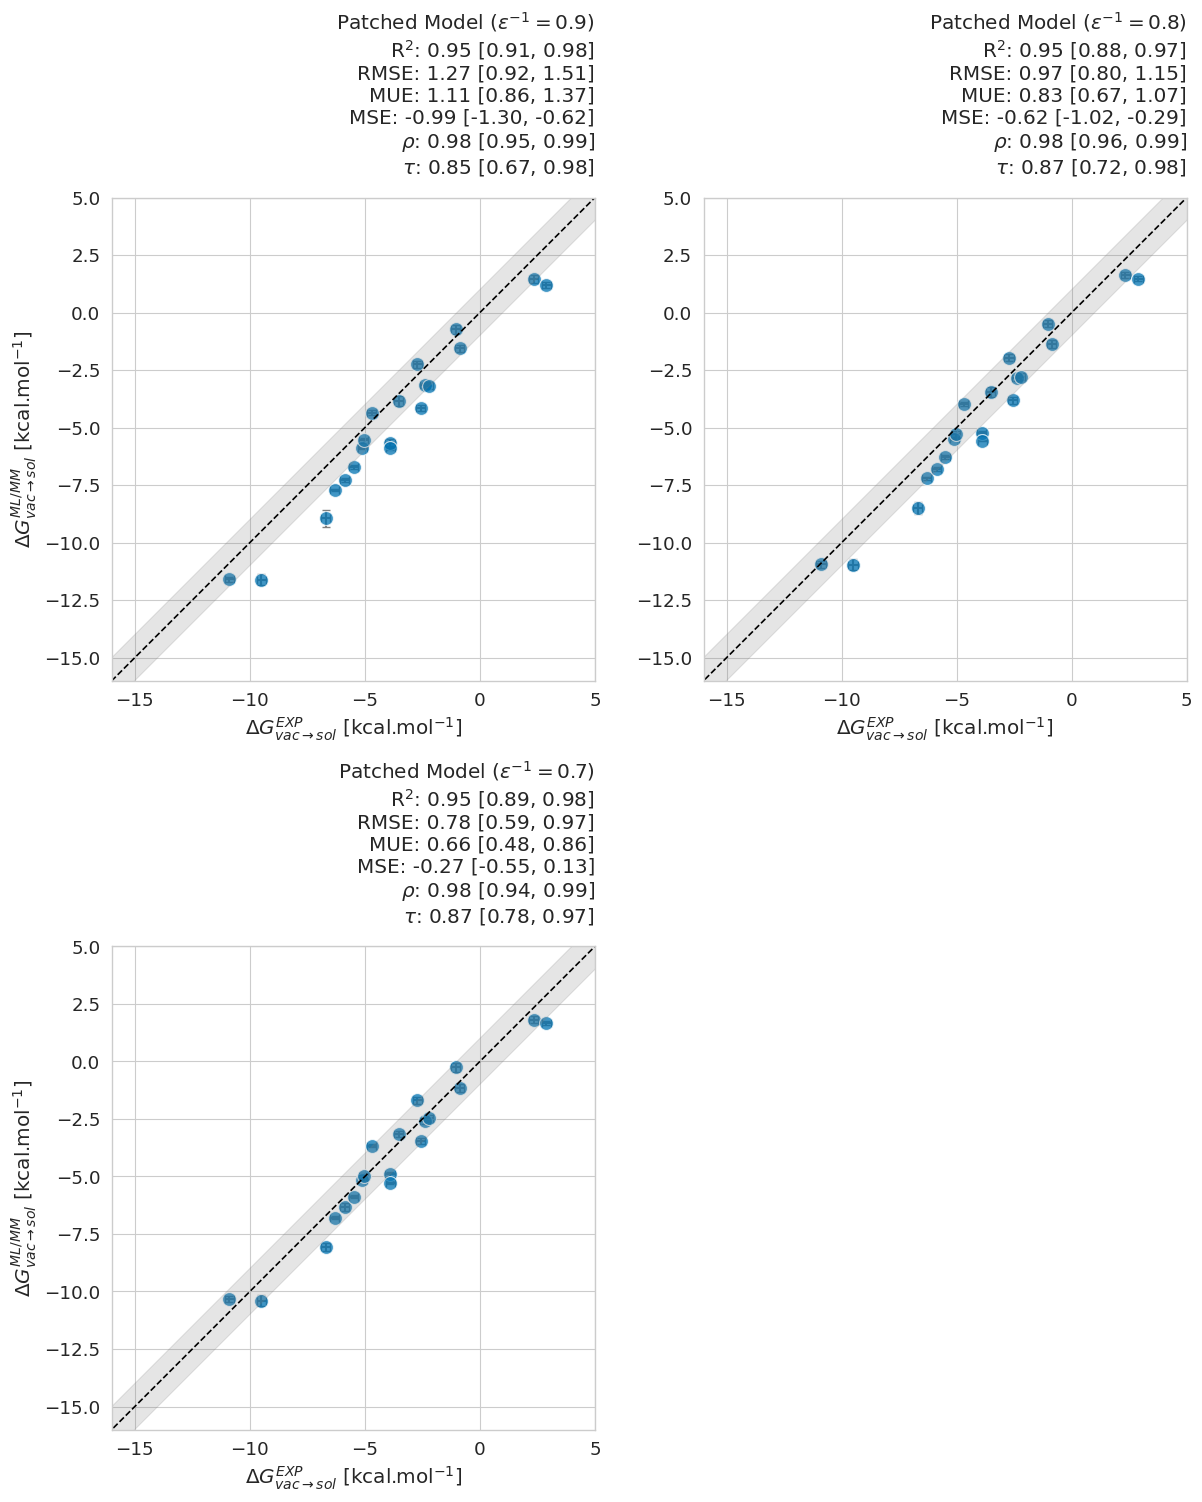

In [8]:
sns.set(style="whitegrid", palette="colorblind", context="paper", font_scale=1.5)

columns_to_plot = df_data_mean.columns[1:]  # Exclude 'EXP'
num_plots = len(columns_to_plot)
ncols = 2
nrows = (num_plots + ncols - 1) // ncols

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(14, 8 * nrows), sharex=False, sharey=False
)

axes = axes.flatten()

# Define y=x line
xx = np.linspace(-100, 100, 100)
yy = xx

for i, column in enumerate(columns_to_plot):
    x = df_data_mean["EXP"]
    y = df_data_mean[column]

    # Bootstrap statistics ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
    metrics = ["R2", "RMSE", "MUE", "MSE", "rho", "KTAU"]
    statistics = {}
    statistics_string = ""
    statistic_type = "mle"
    statistic_name = {
        "RMSE": r"RMSE",
        "MUE": r"MUE",
        "MSE": r"MSE",
        "R2": r"R$^2$",
        "rho": r"$\rho$",
        "KTAU": r"$\tau$",
    }
    for statistic in metrics:
        statistics[statistic] = bootstrap_statistic(x, y, statistic=statistic)
        s = statistics[statistic]
        string = (
            f"{statistic_name[statistic]}: {s[statistic_type]:.2f} [{s['low']:.2f}, {s['high']:.2f}]"
            + "\n"
        )
        statistics_string += string

    sns.lineplot(ax=axes[i], x=xx, y=yy, color="black", linestyle="--")
    sns.scatterplot(ax=axes[i], x=x, y=y, alpha=0.75, s=100)

    axes[i].errorbar(
        x,
        y,
        xerr=df_data_error["EXP"],
        yerr=df_data_error[column],
        fmt="none",  # no marker
        ecolor="gray",
        elinewidth=1.5,
        capsize=3,
        alpha=1.0,
        zorder=0,
    )
    # axes[i].set_title(f'{column}')
    if i in [0, 2]:
        axes[i].set_ylabel(
            r"$\Delta G^{ML/MM}_{vac \rightarrow sol}$ [kcal.mol$^{-1}$]"
        )
    else:
        axes[i].set_ylabel("")

    axes[i].set_xlabel(r"$\Delta G^{EXP}_{vac \rightarrow sol}$ [kcal.mol$^{-1}$]")

    small_dist = 1.0
    scale = np.linspace(-100, 100, 100)
    axes[i].fill_between(
        scale,
        scale - small_dist,
        scale + small_dist,
        color="grey",
        alpha=0.2,
    )

    axes[i].set_title(
        f"{column}\n{statistics_string}",
        loc="right",
        horizontalalignment="right",
        pad=1,
    )

    axes[i].grid(True)
    xmin = ymin = -16
    xmax = ymax = 5
    axes[i].set_xlim(xmin, xmax)
    axes[i].set_ylim(ymin, ymax)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

for ax in axes:
    ax.set_aspect("equal", "box")

# reduce vertical space between subplots
plt.subplots_adjust(hspace=0.55)
plt.savefig("ahfe_benchmark.png", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

# 2D Plot (RMSE Errors)

In [9]:
df_2d = pd.DataFrame(
    {
        "Molecule": df["Molecule"],
        "EXP": EXP_MEAN,
        "EFF_10": dG_EFF_10_MEAN,
        "EFF_09": dG_EFF_09_MEAN,
        "EFF_08": dG_EFF_08_MEAN,
        "EFF_07": dG_EFF_07_MEAN,
    }
)

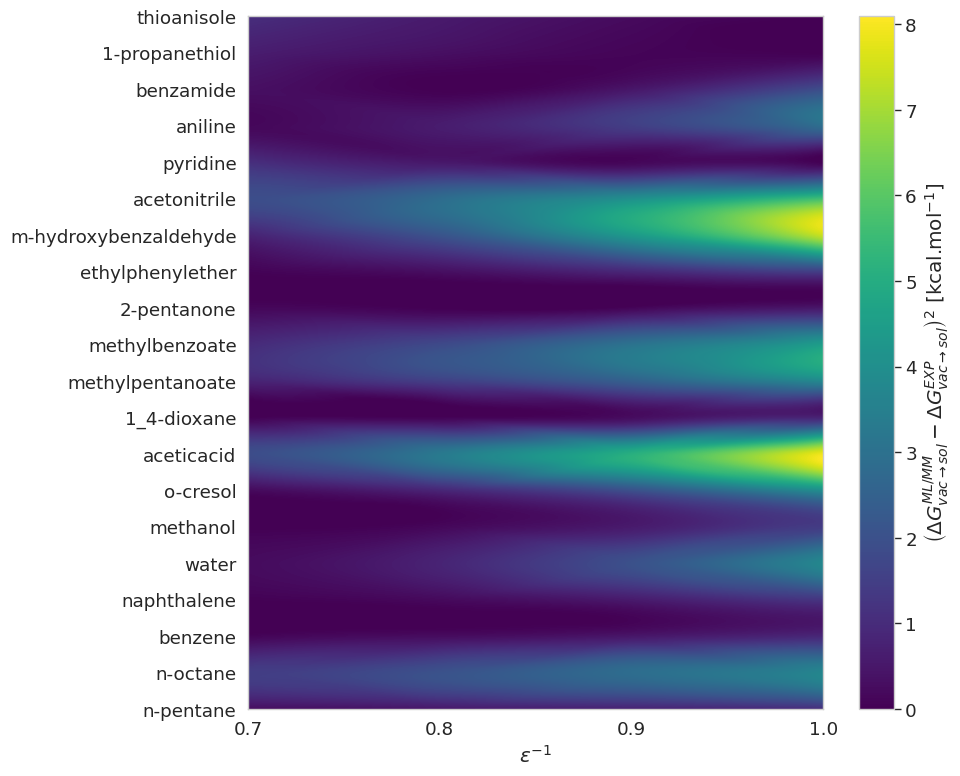

In [10]:
from scipy.interpolate import griddata

sns.set(style="whitegrid", palette="colorblind", context="paper", font_scale=1.5)


# Calculate mean signed errors for each molecule and epsilon]
errors = {"molecule": [], "eps_0.7": [], "eps_0.8": [], "eps_0.9": [], "eps_1.0": []}

for index, row in df_2d.iterrows():
    errors["molecule"].append(row["Molecule"])
    errors["eps_0.7"].append(row["EFF_07"] - row["EXP"])
    errors["eps_0.8"].append(row["EFF_08"] - row["EXP"])
    errors["eps_0.9"].append(row["EFF_09"] - row["EXP"])
    errors["eps_1.0"].append(row["EFF_10"] - row["EXP"])

# Create a DataFrame for interpolation
heatmap_df = pd.DataFrame(errors)
heatmap_df.set_index("molecule", inplace=True)

# Prepare data for interpolation
values = heatmap_df.values
x_labels = ["0.7", "0.8", "0.9", "1.0"]  # Include eps_1.0 in x_labels
y_labels = np.arange(len(heatmap_df))  # y positions for molecules

# Define grid for interpolation
grid_x = np.linspace(0, len(x_labels) - 1, 2500)
grid_y = np.linspace(0, len(y_labels), 2500)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)

# Flatten the original data for interpolation
points = np.array([[j, i] for i in range(len(y_labels)) for j in range(len(x_labels))])
values_flat = values.flatten()
values_flat = values_flat**2

# Perform the interpolation
grid_z = griddata(points, values_flat, (grid_x, grid_y), method="cubic")

# Create the plot
plt.figure(figsize=(10, 8))
plt.imshow(
    grid_z,
    extent=[
        0,
        len(x_labels) - 1,
        0,
        len(y_labels),
    ],  # y limits from 0 to number of molecules
    aspect="auto",
    cmap="viridis",
    interpolation="antialiased",
    origin="lower",
)

# Add color bar
# plt.colorbar(label=r'$\left( \Delta G^{ML/MM}_{vac \rightarrow sol}-\Delta G^{EXP} \right)^2$ [kcal.mol$^{-1}$]')
plt.colorbar(
    label=r"$\left( \Delta G^{ML/MM}_{vac \rightarrow sol}-\Delta G^{EXP}_{vac \rightarrow sol} \right)^2$ [kcal.mol$^{-1}$]"
)

plt.clim(vmin=0)
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
plt.yticks(ticks=np.arange(len(y_labels)), labels=heatmap_df.index)
plt.xlabel(r"$\epsilon^{-1}$")
plt.ylim(0, len(y_labels) - 1)
plt.grid(False)
plt.tight_layout()
plt.savefig("dieletric_error_2d.pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

# Combined Plot

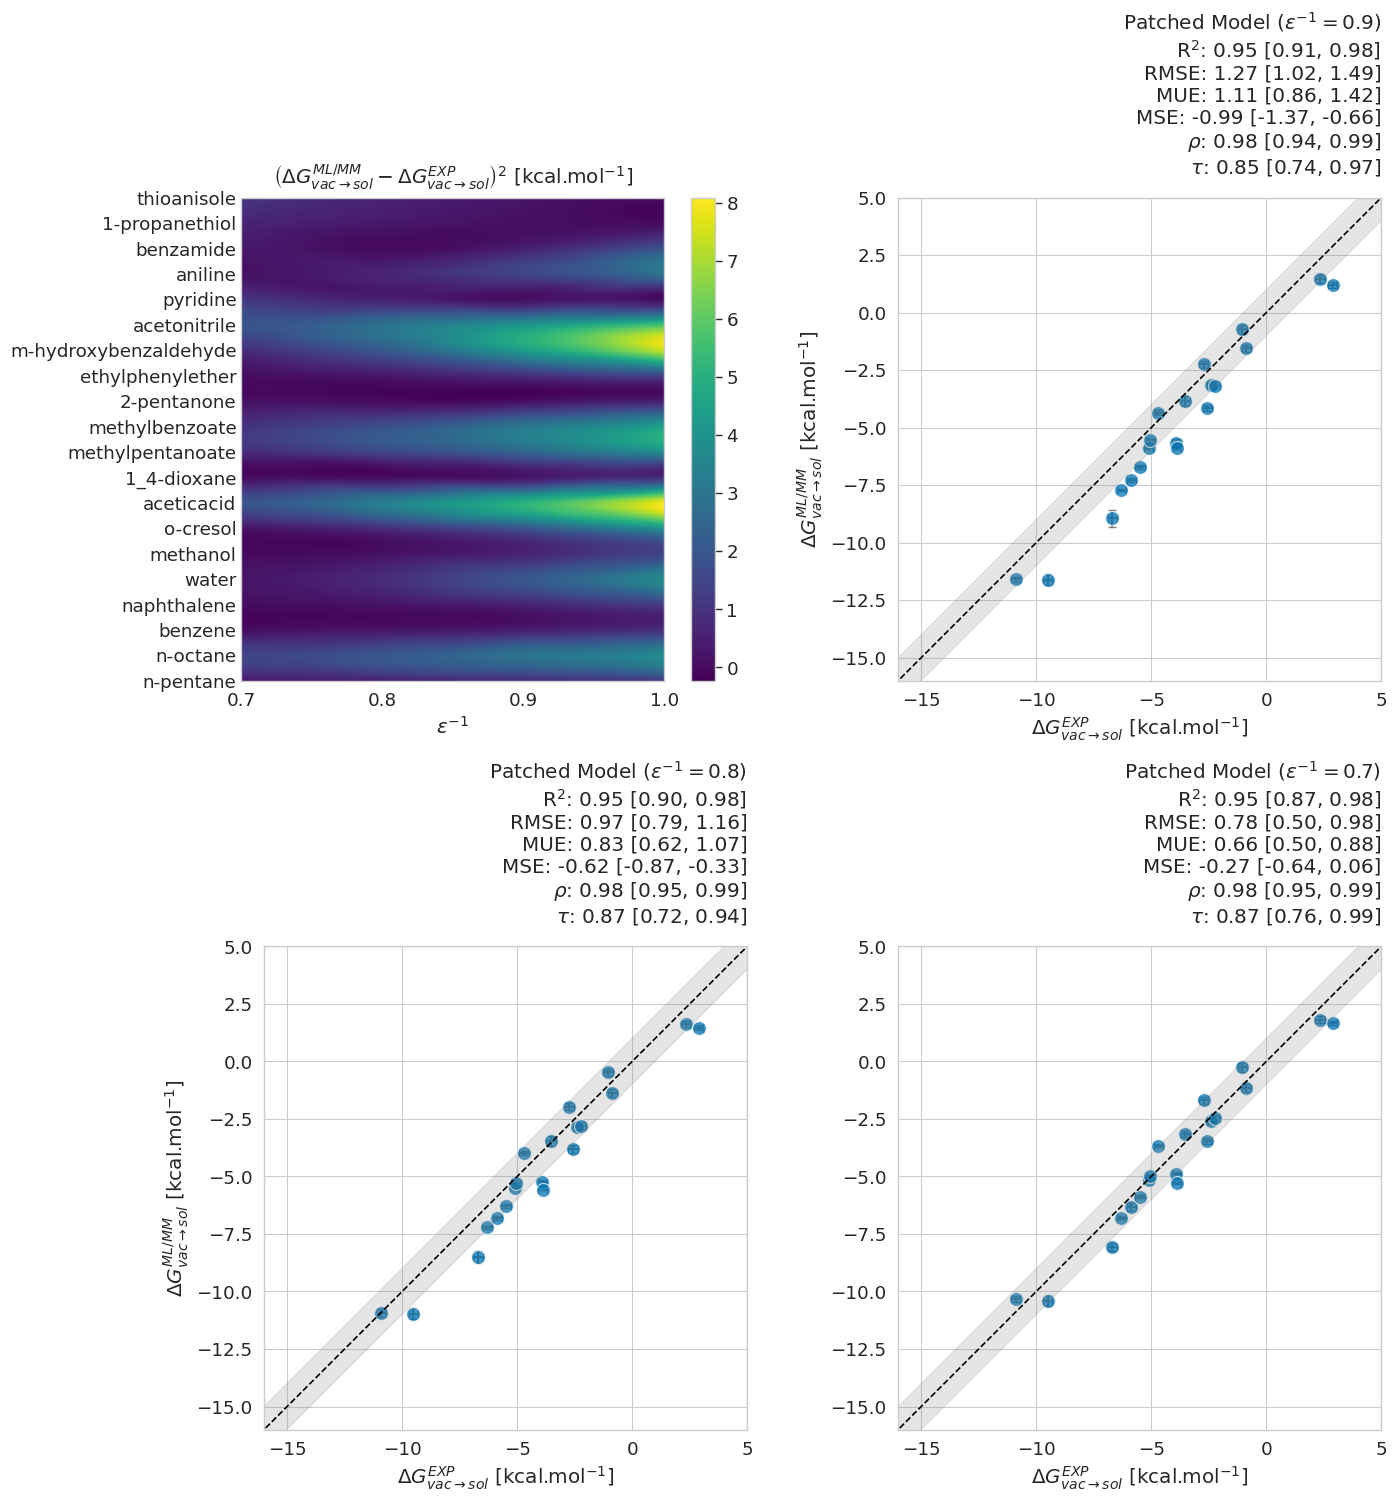

In [19]:
sns.set(style="whitegrid", palette="colorblind", context="paper", font_scale=1.5)

columns_to_plot = df_data_mean.columns[1:]
if len(columns_to_plot) % 2 == 1:
    columns_to_plot = ["PLACEHOLDER_HEATMAP"] + list(columns_to_plot)

ncols = 2
nrows = (len(columns_to_plot) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8 * nrows))
axes = axes.flatten()

# Plot settings
xx = np.linspace(-100, 100, 100)
statistic_name = {
    "RMSE": r"RMSE",
    "MUE": r"MUE",
    "MSE": r"MSE",
    "R2": r"R$^2$",
    "rho": r"$\rho$",
    "KTAU": r"$\tau$",
}

# Generate scatter plots
for i, column in enumerate(columns_to_plot):
    if column == "PLACEHOLDER_HEATMAP":
        continue

    x, y = df_data_mean["EXP"], df_data_mean[column]

    # Calculate statistics
    stats = {
        m: bootstrap_statistic(x, y, statistic=m)
        for m in ["R2", "RMSE", "MUE", "MSE", "rho", "KTAU"]
    }
    stats_str = "\n".join(
        f"{statistic_name[m]}: {s['mle']:.2f} [{s['low']:.2f}, {s['high']:.2f}]"
        for m, s in stats.items()
    )

    sns.lineplot(ax=axes[i], x=xx, y=xx, color="black", linestyle="--")
    sns.scatterplot(ax=axes[i], x=x, y=y, alpha=0.75, s=100)
    axes[i].errorbar(
        x,
        y,
        xerr=df_data_error["EXP"],
        yerr=df_data_error[column],
        fmt="none",
        ecolor="gray",
        elinewidth=1.5,
        capsize=3,
        alpha=1.0,
        zorder=0,
    )

    axes[i].set_ylabel(
        r"$\Delta G^{ML/MM}_{vac \rightarrow sol}$ [kcal.mol$^{-1}$]"
        if i in [1, 2]
        else ""
    )
    axes[i].set_xlabel(r"$\Delta G^{EXP}_{vac \rightarrow sol}$ [kcal.mol$^{-1}$]")
    axes[i].fill_between(xx, xx - 1, xx + 1, color="grey", alpha=0.2)
    axes[i].set_title(
        f"{column}\n{stats_str}\n", loc="right", horizontalalignment="right", pad=1
    )
    axes[i].grid(True)
    axes[i].set_xlim(-16, 5)
    axes[i].set_ylim(-16, 5)

# Heatmap
ax_hm = axes[0]
errors = {
    f"eps_{e}": df_2d[f"EFF_{e.replace('.', '')}"] - df_2d["EXP"]
    for e in ["0.7", "0.8", "0.9", "1.0"]
}
errors["molecule"] = df_2d["Molecule"]
heatmap_df = pd.DataFrame(errors).set_index("molecule")

# Interpolate data
x_labels = ["0.7", "0.8", "0.9", "1.0"]
y_labels = np.arange(len(heatmap_df))
grid_x, grid_y = np.meshgrid(
    np.linspace(0, len(x_labels) - 1, 2500), np.linspace(0, len(y_labels), 2500)
)
points = np.array([[j, i] for i in range(len(y_labels)) for j in range(len(x_labels))])
grid_z = griddata(
    points, heatmap_df.values.flatten() ** 2, (grid_x, grid_y), method="cubic"
)

# Plot
im = ax_hm.imshow(
    grid_z,
    extent=[0, len(x_labels) - 1, 0, len(y_labels)],
    aspect="auto",
    cmap="viridis",
    interpolation="antialiased",
    origin="lower",
)
cbar = fig.colorbar(im)
ax_hm.set_title(
    r"$\left( \Delta G^{ML/MM}_{vac \rightarrow sol} - \Delta G^{EXP}_{vac \rightarrow sol} \right)^2$ [kcal.mol$^{-1}$]", 
    pad=10
)

ax_hm.set_xticks(np.arange(len(x_labels)))
ax_hm.set_xticklabels(x_labels)
ax_hm.set_yticks(np.arange(len(y_labels)))
ax_hm.set_yticklabels(heatmap_df.index)
ax_hm.set_xlabel(r"$\epsilon^{-1}$")
ax_hm.grid(False)
ax_hm.set_ylim(0, len(y_labels) - 1)
ax_hm.tick_params(axis="y", length=0)

for ax in axes:
    ax.set_aspect("auto" if ax == ax_hm else "equal", "box")

plt.subplots_adjust(hspace=0.55)
plt.savefig("dieletric_results.pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()